In [289]:
import os
print(os.getcwd())  # check local
import scipy.optimize
import xarray as xr
import pandas as pd
import numpy as np
import cartopy.mpl.ticker as cticker
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import metpy
import scipy.stats as sts
from glob import glob
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import re
import warnings
import isca_tools
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig
from isca_tools.utils import area_weighting
from isca_tools.utils.base import round_any
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry
from isca_tools.convection.base import lcl_metpy, dry_profile_temp, moist_profile
from isca_tools.thesis.lapse_theory import get_bulk_lapse_rate, reconstruct_temp, interp_var_at_pressure
from isca_tools.utils.moist_physics import sphum_sat
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from statsmodels.stats.multitest import fdrcorrection
from tqdm.notebook import tqdm
import scipy
from geocat.comp.interpolation import interp_hybrid_to_pressure
import copy
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/joshduffield/Documents/StAndrews/Isca/jobs/theory_lapse


In [433]:
# Figure formatting
SMALL_SIZE = 5
MEDIUM_SIZE = 6
BIGGER_SIZE = 7


plt.rc('axes', linewidth=0.5)
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

In [434]:
def get_co2_multiplier(name):
    match = re.match(r'co2_([\d_]+)x', name)
    if match:
        # Replace underscore with decimal point and convert to float
        return float(match.group(1).replace('_', '.'))
    elif name == 'pre_industrial':
        return 1  # for pre_industrial or other defaults
    else:
        raise ValueError(f'Not valid name = {name}')

In [435]:
exp_name = ['pre_industrial', 'co2_2x']
n_exp = len(exp_name)
exp_path = lambda x: f'/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/theory_adiabat/above_quant_2m_500hPa/{x}/all_days/output_lev_quant95.nd2'
ds = [xr.open_dataset(exp_path(var)).isel(quant=0) for var in exp_name]
ds = xr.concat(ds, dim=xr.DataArray([get_co2_multiplier(exp_name[i]) for i in range(n_exp)], name='co2', dims='co2'))

In [436]:
# Land masks
# The year for the land-sea mask matters. Not surprising due to glaciers melting. Zhang used 1979 mask.
invariant_data = xr.open_dataset('/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/input_data/fv_0.9x1.25_nc3000_Nsw042_Nrs008_Co060_Fi001_ZR_sgh30_24km_GRNL_c170103.nc')[['LANDFRAC', 'PHIS']]
invariant_data = invariant_data.reindex_like(ds['PS'], method="nearest", tolerance=0.01).load()
# lsm = lsm_zhang
land = invariant_data['LANDFRAC'].where(invariant_data['LANDFRAC']>0.5)*0+1
ocean = invariant_data['LANDFRAC'].where(invariant_data['LANDFRAC']<=0.5)*0+1
weights = np.cos(np.deg2rad(invariant_data.lat))
z2m = invariant_data.PHIS/g + 2

In [437]:
def initialize_ax_projection(ax, lon_min=-180, lon_max=180, lat_min=30, lat_max=80,
                             grid_lon=np.arange(-180,180.01,60), grid_lat=np.asarray([40, 65])):
    ax.coastlines(color='k', linewidth=1)
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    gl = ax.gridlines(ccrs.PlateCarree(), xlocs=grid_lon, ylocs=grid_lat, linestyle=':',
                      color='k', alpha=1, draw_labels=True)
    gl.right_labels=0
    gl.top_labels=0
    return ax

def plot_contour_projection(ax, var, levels=None, n_levels=10, mask=land, cmap='viridis'):
    data, lon = add_cyclic_point(var * (1 if mask is None else mask), coord=var.lon.values, axis=1)
    if levels is None:
        levels = np.linspace(var.min(), var.max(), n_levels)
    im = ax.contourf(lon, var.lat.values, data, transform=ccrs.PlateCarree(),
                     levels=levels, extend='both', cmap=cmap)
    return im

In [438]:
# Account for regions where LCL outside the range between REFHT and pressure_ft
pressure_ft = 500 * 100
# Replace T_at_lcl with TREFHT wherever p_at_lcl closer to surface than PREFHT
ds['T_at_lcl'] = ds['T_at_lcl'].where(ds.p_at_lcl < ds.PREFHT, ds.TREFHT)
ds['T_at_lcl'] = ds['T_at_lcl'].where(ds.p_at_lcl > pressure_ft, ds.T_zonal_av+ds.T_anom)         # where p_at_lcl further from surface than FT, set to FT
# Do same with p_at_lcl
ds['p_at_lcl'] = ds['p_at_lcl'].where(ds.p_at_lcl < ds.PREFHT, ds.PREFHT)
ds['p_at_lcl'] = ds['p_at_lcl'].where(ds.p_at_lcl > pressure_ft, pressure_ft)
ds['sigma_at_lcl'] = ds['p_at_lcl'] / ds.PREFHT

In [439]:
ds['lapse_below_lcl'] = get_bulk_lapse_rate(ds.TREFHT, ds.T_at_lcl, ds.PREFHT, ds.p_at_lcl) * 1000
ds['lapse_below_lcl'] = ds['lapse_below_lcl'].where(ds.p_at_lcl < ds.PREFHT, 0)         # set to 0 where p_at_lcl = PREFHT
ds['lapse_above_lcl'] = get_bulk_lapse_rate(ds.T_at_lcl, ds.T_zonal_av+ds.T_anom, ds.p_at_lcl, pressure_ft) * 1000
ds['lapse_above_lcl'] = ds['lapse_above_lcl'].where(ds.p_at_lcl > pressure_ft, 0)         # set to 0 where p_at_lcl = pressure_ft

In [440]:
def get_var_anom(var, n_lat_av=30, mask=land>0):
    # rolling average over n_lat_av latitude coordinates
    var_av = var.mean(dim='sample').where(mask).median(dim='lon').rolling(lat=n_lat_av, center=True).median(dim='lat')
    return var.where(mask) - var_av
# get_var_anom(ds, norm_n_lat, mask=mask).sel(lat=slice(lat_min, lat_max))

In [441]:
lat_min = 40
lat_max = 65
do_norm = False
norm_n_lat = 30
mask = np.logical_and(z2m < 1000, land>0)       # only consider land regions less than 1km in height
# mask = land > 0
if do_norm:
    ds = get_var_anom(ds, norm_n_lat, mask=mask).sel(lat=slice(lat_min, lat_max)).load()
else:
    ds = ds.where(mask).sel(lat=slice(lat_min, lat_max)).load()

### Correlation between `T_zonal_av` and `dayofyear`
Just to illustrate that `T_zonal_av` is almost purely a function of `dayofyear` i.e. an insolation effect.

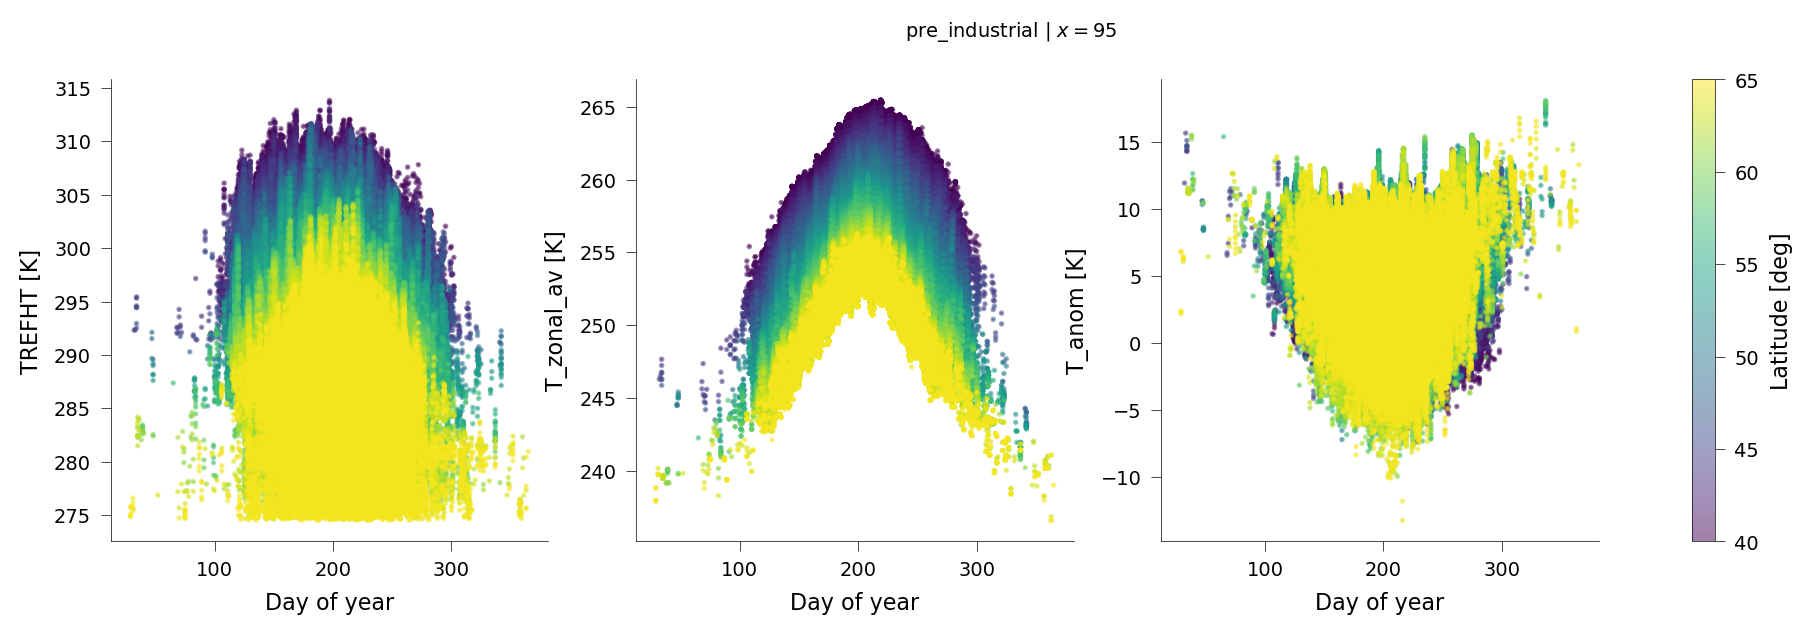

In [442]:
i = 0
fig, ax = plt.subplots(1, 3, sharex=True)
fig_resize(fig, 4*3)
ax[0].scatter(ds.dayofyear.isel(co2=i), ds.TREFHT.isel(co2=i), s=1, c=ds.dayofyear.isel(co2=i)*0+ds.lat, alpha=0.5, vmin=lat_min, vmax=lat_max)
ax[1].scatter(ds.dayofyear.isel(co2=i), ds.T_zonal_av.isel(co2=i), s=1, c=ds.dayofyear.isel(co2=i)*0+ds.lat, alpha=0.5, vmin=lat_min, vmax=lat_max)
im = ax[2].scatter(ds.dayofyear.isel(co2=i), ds.T_anom.isel(co2=i), s=1, c=ds.dayofyear.isel(co2=i)*0+ds.lat, alpha=0.5, vmin=lat_min, vmax=lat_max)
plt.colorbar(im, ax=ax.ravel(), label='Latitude [deg]')
ax[0].set_xlabel('Day of year')
ax[1].set_xlabel('Day of year')
ax[2].set_xlabel('Day of year')
ax[0].set_ylabel('TREFHT [K]')
ax[1].set_ylabel('T_zonal_av [K]')
ax[2].set_ylabel('T_anom [K]')
fig.suptitle(f"{exp_name[i]} | $x={ds.quant:.0f}$")
plt.show()

## Principal Component Analysis
Below, I get the principal components over 5 variables that come into the lapse rate coupling, to illustrate their inter-relation. I think it makes most sense to do a spatial normalization first using `do_norm` above. This then answers the question as to why is region A warmer than the zonal average expectation.

In [443]:
var_pca = ['T_zonal_av', 'T_anom', 'lapse_below_lcl', 'lapse_above_lcl', 'sigma_at_lcl']
keep_ind = [np.where(~np.isnan(ds.T_zonal_av.isel(co2=i).values.flatten()))[0] for i in range(n_exp)]
X = []
for i in range(n_exp):
    X.append(np.column_stack([ds[key].isel(co2=i).values.flatten() for key in var_pca]))

In [444]:
ind_pca_exp = 0         # find PCA using these indices
scaler = StandardScaler()
X_scaled = [np.full_like(X[i], np.nan) for i in range(n_exp)]
X_scaled[ind_pca_exp][keep_ind[ind_pca_exp]] = scaler.fit_transform(X[ind_pca_exp][keep_ind[ind_pca_exp]])

X_lat = (0*ds.dayofyear.isel(co2=ind_pca_exp).fillna(0) + ds.lat).values.flatten()
X_lon = (0*ds.dayofyear.isel(co2=ind_pca_exp).fillna(0) + ds.lon).values.flatten()

In [445]:
n_comp = 3
pca = PCA(n_components=n_comp)
X_pca = [np.full((X[i].shape[0], n_comp), np.nan) for i in range(n_exp)]
X_pca[ind_pca_exp][keep_ind[ind_pca_exp]] = pca.fit_transform(X_scaled[ind_pca_exp][keep_ind[ind_pca_exp]])

# Apply PCA found using ind_pca_exp to other exps
for i in range(n_exp):
    if i == ind_pca_exp:
        continue
    X_scaled[i][keep_ind[i]] = scaler.transform(X[i][keep_ind[i]])          # normalise according to that of ind_pca_exp
    X_pca[i][keep_ind[i]] = pca.transform(X_scaled[i][keep_ind[i]])         # find coefficients in PC space of ind_pca_exp

In [446]:
pbar = tqdm(total=n_exp*ds.lat.size*ds.lon.size)
X_pca_grid = np.full((n_exp, ds.lat.size, ds.lon.size, ds.sample.size, n_comp), np.nan)
for i in range(ds.lat.size):
    for j in range(ds.lon.size):
        ind = np.where(np.logical_and(np.abs(X_lat-ds.lat.values[i])<0.1, np.abs(X_lon-ds.lon.values[j])<0.1))[0]
        if len(ind) == 0:
            pbar.update(n_exp)
            continue
        for k in range(n_exp):
            X_pca_grid[k, i, j, :len(ind)] = X_pca[k][ind]
            pbar.update(1)
pbar.close()
X_pca_grid = xr.DataArray(
    X_pca_grid,
    dims=('co2', 'lat', 'lon', 'sample', 'pc'),
    coords={'co2': ds.co2, 'lat': ds.lat, 'lon': ds.lon, 'sample': ds.sample, 'pc': np.arange(n_comp)},
    name='pc_coef'
)

  0%|          | 0/15552 [00:00<?, ?it/s]

### Single Climate


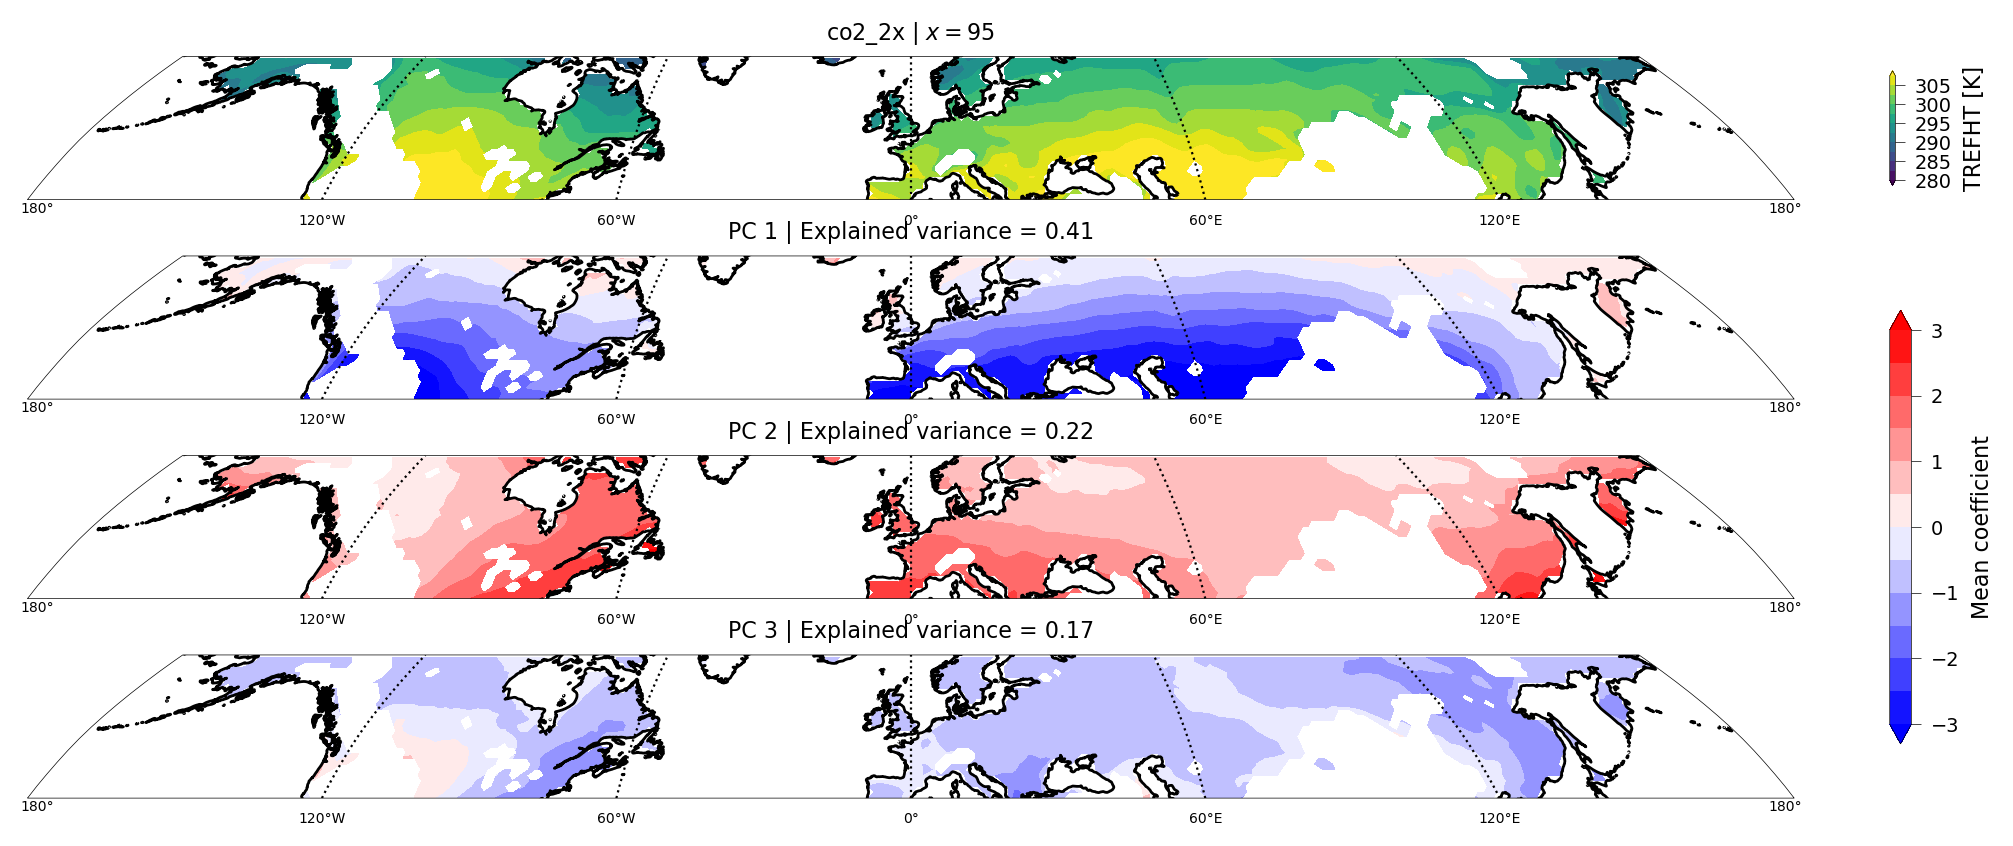

In [448]:
j = 1
fig = plt.figure(constrained_layout=True,figsize=(10.,4))
ax = fig.subplots(n_comp+1, 1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
initialize_ax_projection(ax[0], lat_min=lat_min, lat_max=lat_max)
im = plot_contour_projection(ax[0], ds.TREFHT.isel(co2=j).mean(dim='sample'), levels=np.arange(-5, 5.5, 0.5) if do_norm else np.arange(280, 310, 2.5),
                             cmap='bwr' if do_norm else 'viridis')
plt.colorbar(im, ax=ax[0], label='TREFHT [K]', shrink=0.8)
for i in range(n_comp):
    initialize_ax_projection(ax[i+1], lat_min=lat_min, lat_max=lat_max)
    im = plot_contour_projection(ax[i+1], X_pca_grid.isel(co2=j, pc=i).mean(dim='sample'), levels=np.arange(-3, 3.5, 0.5), cmap='bwr')
    ax[i+1].set_title(f'PC {i+1} | Explained variance = {pca.explained_variance_ratio_[i]:.2f}')
plt.colorbar(im, ax=ax[1:].ravel(), label='Mean coefficient', shrink=0.8)
ax[0].set_title(f"{exp_name[j]} | $x={ds.quant:.0f}$")
plt.show()

### Change with warming

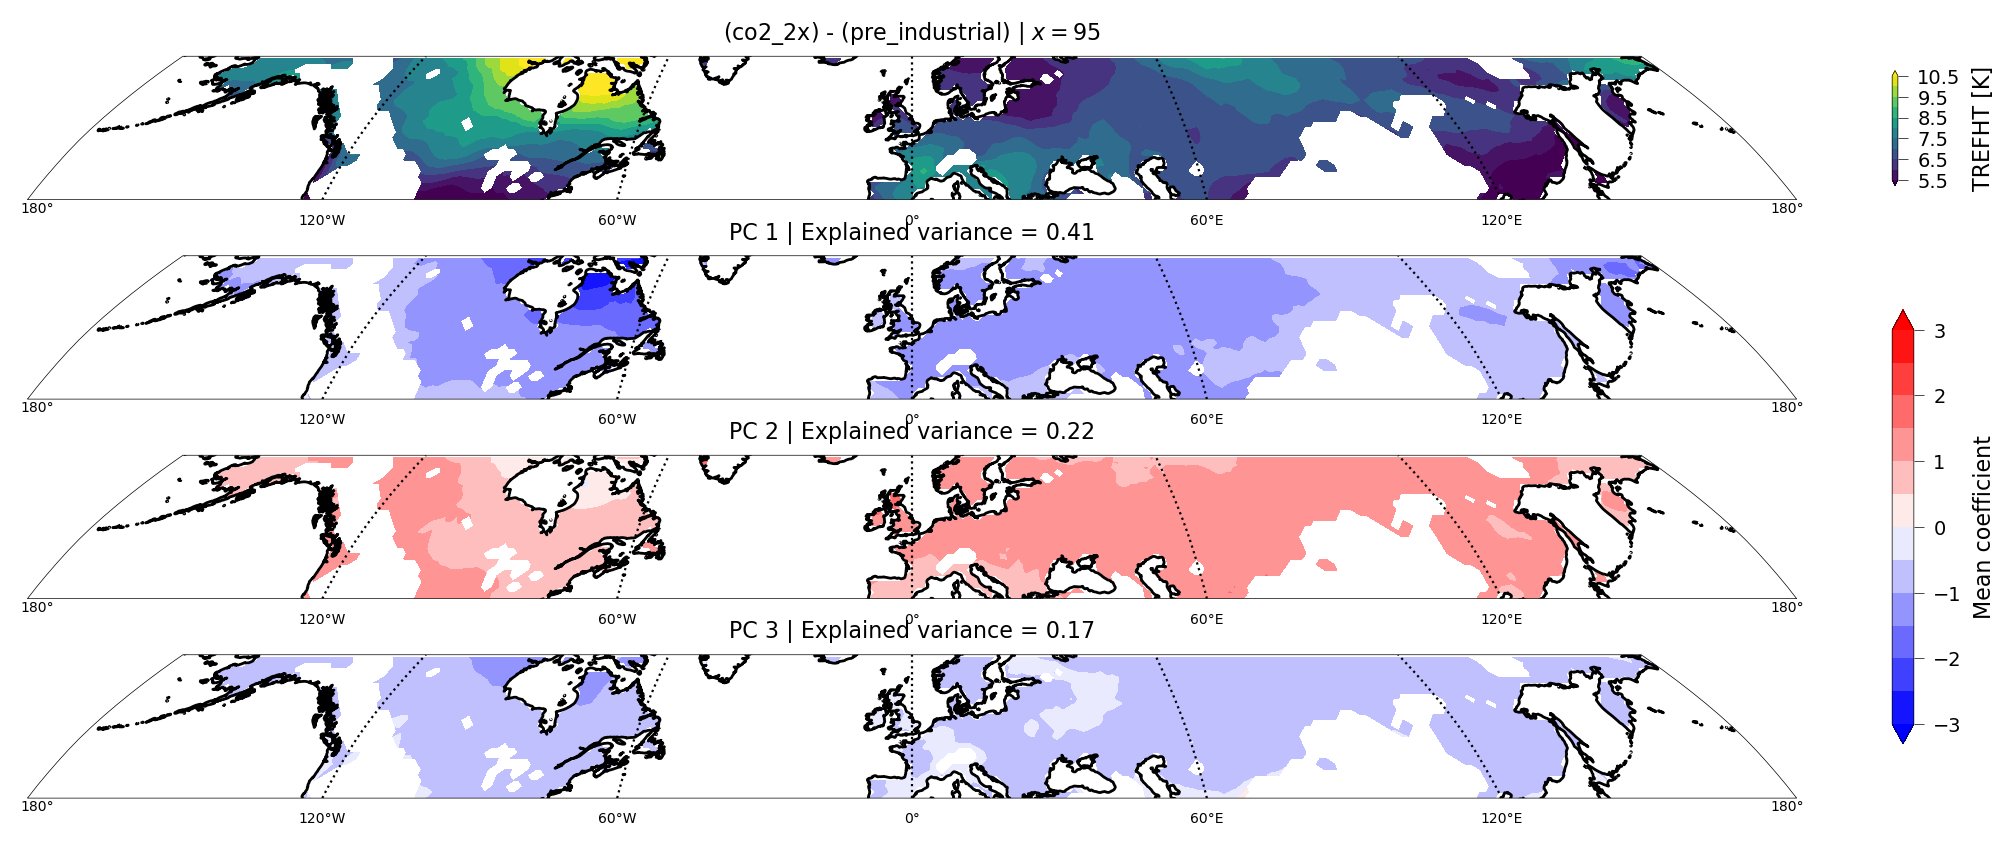

In [452]:
fig = plt.figure(constrained_layout=True,figsize=(10.,4))
ax = fig.subplots(n_comp+1, 1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
initialize_ax_projection(ax[0], lat_min=lat_min, lat_max=lat_max)
im = plot_contour_projection(ax[0], ds.TREFHT.isel(co2=1).mean(dim='sample') - ds.TREFHT.isel(co2=0).mean(dim='sample'),
                             levels=np.arange(-5, 5.5, 0.5) if do_norm else np.arange(5.5, 11, 0.5),
                             cmap='bwr' if do_norm else 'viridis')
plt.colorbar(im, ax=ax[0], label='TREFHT [K]', shrink=0.8)
for i in range(n_comp):
    initialize_ax_projection(ax[i+1], lat_min=lat_min, lat_max=lat_max)
    im = plot_contour_projection(ax[i+1], X_pca_grid.isel(co2=1, pc=i).mean(dim='sample') -
                                 X_pca_grid.isel(co2=0, pc=i).mean(dim='sample'), levels=np.arange(-3, 3.5, 0.5), cmap='bwr')
    ax[i+1].set_title(f'PC {i+1} | Explained variance = {pca.explained_variance_ratio_[i]:.2f}')
plt.colorbar(im, ax=ax[1:].ravel(), label='Mean coefficient', shrink=0.8)
ax[0].set_title(f"({exp_name[1]}) - ({exp_name[0]}) | $x={ds.quant:.0f}$")
plt.show()

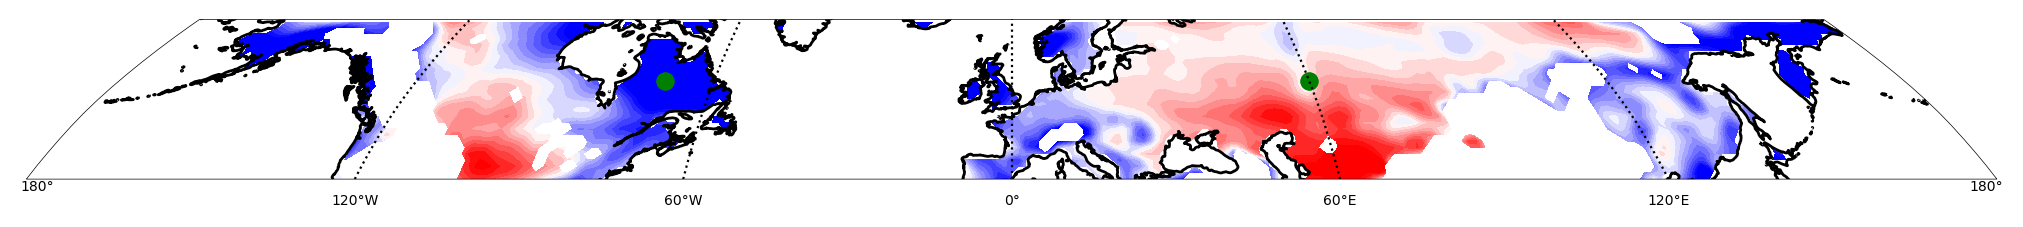

In [425]:
j = 0
show_plot_loc = True
fig = plt.figure(constrained_layout=True,figsize=(10.,4))
ax = fig.subplots(1,1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
initialize_ax_projection(ax, lat_min=lat_min, lat_max=lat_max)
plot_contour_projection(ax, ds.TREFHT.mean(dim='sample').isel(co2=j), levels=np.arange(-5, 5.5, 0.5) if do_norm else np.arange(280, 310, 2.5),
                             cmap='bwr' if do_norm else 'viridis')
# fig, ax = plt.subplots(1, 1, subplot_kw={'projection': proj})
# ax.pcolormesh(ds.lon, ds.lat, ds.TREFHT.mean(dim='sample'), transform=ccrs.PlateCarree())
# ax.set_extent([0, 360, lat_min, lat_max], crs=ccrs.PlateCarree())
# def lon_formatter(x, pos):
#     """Format longitudes from 0 to 360 without E/W"""
#     x = x % 360  # wrap into 0–360
#     return f"{int(x)}°"
# gl.xformatter = FuncFormatter(lon_formatter)
# gl.yformatter = cticker.LatitudeFormatter()
lon_plot = [60, 290]
lat_plot = [55, 55]
for i in range(len(lon_plot)):
    ax.scatter(lon_plot, lat_plot, s=50, marker='.', c='g' if do_norm else 'r', lw=3, alpha=1, transform=ccrs.PlateCarree())
if show_plot_loc:
    plt.show()
else:
    plt.close()

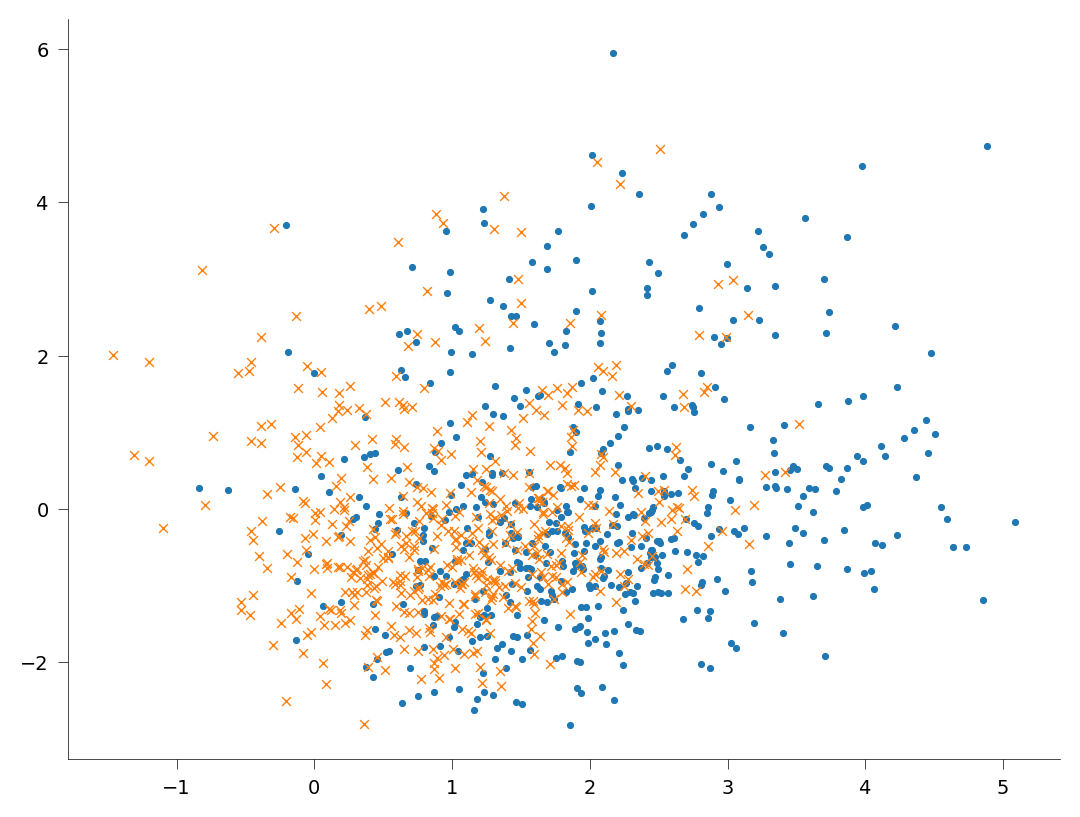

In [432]:
j = 0
for i in range(len(lon_plot)):
    if i==0:
        continue
    plot_ind = np.logical_and(np.abs(X_lat-lat_plot[i])<0.2, np.abs(X_lon-lon_plot[i])<0.2)
    for j in range(n_exp):
        plt.scatter(X_pca[j][plot_ind, 0], X_pca[j][plot_ind, 1], s=10, color=f"C{i}", marker=['.', 'x'][j])

In [420]:
loadings = pca.components_.T  # shape: (variables, components)

for i, pc_loadings in enumerate(loadings.T, 1):
    print(f"\nPC{i} loadings:")
    for var, loading in zip(var_pca, pc_loadings):
        print(f"  {var:20s}: {loading:.2f}")


PC1 loadings:
  T_zonal_av          : 0.24
  T_anom              : 0.13
  lapse_below_lcl     : -0.54
  lapse_above_lcl     : -0.49
  sigma_at_lcl        : 0.63

PC2 loadings:
  T_zonal_av          : -0.68
  T_anom              : 0.71
  lapse_below_lcl     : -0.18
  lapse_above_lcl     : -0.00
  sigma_at_lcl        : -0.04

PC3 loadings:
  T_zonal_av          : -0.16
  T_anom              : -0.28
  lapse_below_lcl     : -0.55
  lapse_above_lcl     : 0.74
  sigma_at_lcl        : 0.22
